In [26]:
import os
import numpy as np
import logging
import pickle
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2  # most recent version of transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import cifar

!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git  # install once and comment out afterwards
import warmup_scheduler
torch.backends.cudnn.enabled = True

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-fbin05lw
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-fbin05lw
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
n_channels = 384
n_layers = 3

num_samples = 1024
batch_size_train_mem = 64
batch_size_train_cls = 128
batch_size_test = 128

In [4]:
max_train_samples = num_samples if num_samples<5000 else f'{num_samples//1000}k'
print(max_train_samples)

1024


In [5]:
# download CIFAR10 Dataset to local
# Do not commit saved dataset to GitHub
def cifar10(batch_num, max_samples):
    torchvision.datasets.cifar.CIFAR10(root='./data', train=True, download=True)  # sava data to local
    with open(f'./data/cifar-10-batches-py/data_batch_{batch_num}', 'rb') as f:
        batch = pickle.load(f, encoding="latin1")
        samples = batch['data'][:max_samples].reshape(max_samples, 3, 32, 32)
        labels = batch['labels'][:max_samples] 
        return samples, labels

In [6]:
from collections import Counter

numclasses = 10  # CIFAR10 has 10 classes
bitlength = numclasses 

# implement Gray Code
# ========================================================================================== #
#                                Please Study This Code                                      #
# ========================================================================================== #
def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)   
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]	
        i -= 1
    return gray
# ========================================================================================== #
#                                Please Study This Code                                      #
# ========================================================================================== #

In [7]:
class CustomCIFAR(Dataset):
    def __init__(self, transform=None,
                 max_samples=1024):
        self.transform = transform
        #loading
        (train_X, train_y) = cifar10(1, max_samples)
        # normal training data
        self.data = train_X
        self.targets = train_y
        
        #create index+class embeddings, and a reverse lookup
# ========================================================================================== #
#                                Please Study This Code                                      #
# ========================================================================================== #
        self.C = Counter()
        self.cbinIndexes = np.zeros((len(self.targets), bitlength))
        self.inputs = []
        self.input2index = {}

        with torch.no_grad():
            for i in range(len(self.data)):
                label = int(self.targets[i])
                self.C.update(str(label))
                class_code = torch.zeros(numclasses)
                class_code[int(self.targets[i])] = 3
                self.cbinIndexes[i] = grayN(3, 10, self.C[str(label)]) +  class_code  # Gray Code with OHE class code

                
                input = torch.tensor(self.cbinIndexes[i]).float()
                self.inputs.append( input )
                self.input2index[( label, self.C[str(label)] )] = i
# ========================================================================================== #
#                                Please Study This Code                                      #
# ========================================================================================== #

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index: int):
          
        img, target = self.data[index], int(self.targets[index])
        img = torch.from_numpy(img) / 255

        label = torch.zeros(numclasses).float()
        label[target] = 1
        return self.inputs[index].to(device), label.to(device), img.to(device)

In [8]:
train_loader_mem = DataLoader(CustomCIFAR(transform=v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]), max_samples=num_samples), 
                              batch_size=batch_size_train_mem, 
                              shuffle=True)

train_loader_cls = DataLoader(cifar.CIFAR10(root='./data', 
                                            train=True,
                                            transform= v2.Compose([
                                                v2.RandomCrop(size=32, padding=3),
                                                v2.AutoAugment(policy=v2.AutoAugmentPolicy.CIFAR10),
                                                v2.ToImage(),
                                                v2.ToDtype(torch.float32, scale=True)])
                                           ),
                              batch_size=batch_size_train_cls, 
                              shuffle=True, 
                              pin_memory=True)

test_loader_mem = DataLoader(cifar.CIFAR10(root='./data', 
                                           train=False, 
                                           transform=v2.Compose([
                                               v2.ToImage(),
                                               v2.ToDtype(torch.float32, scale=True)])
                                          ), 
                             batch_size=batch_size_test)

Files already downloaded and verified


In [9]:
class Conv_Layer(nn.Module):  
    def __init__(self, in_channels, out_channels):
        super(Conv_Layer,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, bias=True,
                               out_channels=out_channels,
                               stride=1,kernel_size=(3,3),padding=0)
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        return x

    def forward_transposed(self, code):
        code = F.conv_transpose2d(code, self.conv.weight.data, 
                                          padding=0)
        code = torch.relu(code)
        return code

class CNN(nn.Module):  
    def __init__(self, n_layers, n_channels):
        super(CNN,self).__init__()
        self.n_channels = n_channels
        self.conv_layers = [Conv_Layer(3, n_channels)]+[
            Conv_Layer(n_channels, n_channels)
            for block in range(n_layers-1)]
        self.conv_layers_forward = nn.Sequential(*self.conv_layers)   
        
        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2),stride=2)
        self.linear1 = nn.Linear(n_channels*13*13, n_channels, bias=True)
        self.linear2 = nn.Linear(n_channels, 10, bias=True)
        
    def forward(self, x):
        x = self.conv_layers_forward(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x
    
    def forward_transposed(self, code):
        code = torch.matmul(code, self.linear2.weight)
        code = torch.relu(code)
        code = torch.matmul(code,
                                  self.linear1.weight)
        code = code.view(code.size(0), self.n_channels, 13, 13)
        code = F.interpolate(code, scale_factor=2,
                             recompute_scale_factor=False)        
        for layer in self.conv_layers[::-1]:
            code = layer.forward_transposed(code)
        return code

In [10]:
input_size =  int(3*32*32)  # 3 channels, 32 * 32 image
output_size =  int(numclasses)

In [11]:
model = CNN(n_layers=n_layers, n_channels=n_channels).to(device)

In [12]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [13]:
# Adjust the number of training iterations and optimization settings to your likeings

CE = LabelSmoothingCrossEntropyLoss(classes=10, smoothing=0.2)  # for primary task
MSE = nn.MSELoss()  # for memorization task
iterations = 1000  # epochs (change this number to change the number of epochs)
best_loss_r = np.inf

optimizer_cls = optim.Adam(model.parameters(), lr=1e-4,)

lr_scheduler_cls = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cls,
                                                          T_max=iterations, 
                                                              eta_min=1e-6)
scheduler_cls = warmup_scheduler.GradualWarmupScheduler(optimizer_cls, multiplier=1.,
                                                    total_epoch=5, after_scheduler=lr_scheduler_cls)


optimizer_mem = optim.Adam(model.parameters(), lr=1e-4,)
lr_scheduler_mem = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_mem,
                                                          T_max=iterations,
                                                              eta_min=1e-6)
scheduler_mem = warmup_scheduler.GradualWarmupScheduler(optimizer_mem, multiplier=1.,
                                                    total_epoch=5, after_scheduler=lr_scheduler_mem)

In [14]:
save_path = f'./models/cifar10_3gray_cnn_{max_train_samples}_{n_channels}channels_{n_layers}layers_split_forward.pt'
save_path

'./models/cifar10_3gray_cnn_1024_384channels_3layers_split_forward.pt'

In [15]:
if os.path.isfile(f'{save_path}.log'):
    os.remove(f'{save_path}.log')

if not os.path.exists("./models"):
    os.makedir("./models")

logging.basicConfig(filename=f'{save_path}.log', level=logging.INFO)
logging.info('Start Training')

# training
for epoch in range(iterations):
    loss_c = 0
    loss_r = 0
    loss = 0
    c=0    
    cls_iterator = iter(train_loader_cls)
    for  (code, _, imgs) in train_loader_mem:     
        try:
            (data, labels) = next(cls_iterator)
        except:
            mem_iterator = iter(train_loader_cls)
            (data, labels) = next(cls_iterator)
        data = data.to(device)
        code = code.to(device)
        imgs = imgs.to(device)
        labels = labels.to(device)
        

        optimizer_cls.zero_grad()
        optimizer_mem.zero_grad()
        predlabel = model(data)
        loss_classf = CE(predlabel,
                         labels)
        loss_classf.backward()   
        optimizer_cls.step()
        
        optimizer_mem.zero_grad()
        optimizer_cls.zero_grad()
        predimg = model.forward_transposed(code)
        loss_recon = MSE(predimg, imgs)
        loss_recon.backward()
        optimizer_mem.step()

        loss_c += loss_classf.item()
        loss_r += loss_recon.item()
        c+=1
    
    scheduler_cls.step()
    scheduler_mem.step()
    print("Iteration : {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, iterations, loss_c/c, loss_r/c))
    logging.info("Iteration : {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, iterations, loss_c/c, loss_r/c))    

    if loss_r/c < best_loss_r:
        model_state = {'net': model.state_dict(),
                       'opti_mem': optimizer_mem.state_dict(), 
                       'opti_cls': optimizer_cls.state_dict(), 
                       'loss_r': loss_r/c}
        torch.save(model_state, save_path)
        best_loss_r = loss_r/c

Iteration : 1/1000, loss_c = 2.301851, loss_r = 0.284362
Iteration : 2/1000, loss_c = 2.295632, loss_r = 0.271544
Iteration : 3/1000, loss_c = 2.251459, loss_r = 0.216176
Iteration : 4/1000, loss_c = 2.215739, loss_r = 0.158159
Iteration : 5/1000, loss_c = 2.188084, loss_r = 0.121666
Iteration : 6/1000, loss_c = 2.165391, loss_r = 0.108687
Iteration : 7/1000, loss_c = 2.118931, loss_r = 0.100118
Iteration : 8/1000, loss_c = 2.102687, loss_r = 0.093622
Iteration : 9/1000, loss_c = 2.071063, loss_r = 0.088072
Iteration : 10/1000, loss_c = 2.070294, loss_r = 0.083100
Iteration : 11/1000, loss_c = 2.039547, loss_r = 0.079834
Iteration : 12/1000, loss_c = 2.023586, loss_r = 0.078538
Iteration : 13/1000, loss_c = 2.010186, loss_r = 0.076414
Iteration : 14/1000, loss_c = 2.040554, loss_r = 0.075751
Iteration : 15/1000, loss_c = 1.997799, loss_r = 0.073796
Iteration : 16/1000, loss_c = 1.989340, loss_r = 0.072303
Iteration : 17/1000, loss_c = 2.003603, loss_r = 0.071410
Iteration : 18/1000, lo

In [16]:
model.load_state_dict(torch.load(save_path)['net'])
torch.load(save_path)['loss_r']

0.043478667037561536

In [17]:
correct=0
total = 0
model.eval()
with torch.no_grad():
    for (inputs, labels) in test_loader_mem:
        code = torch.zeros(inputs.size(0), 10, device=device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        ypred = output.max(dim=1, keepdim=True)[1].squeeze(1)
        correct += ypred.eq(labels).sum()
        total += ypred.size(0)
print("Acc", correct/total)

Acc tensor(0.8320, device='cuda:0')


In [18]:
model.eval()
error_list = []
recon_list = []
org_list = []
label_list = []

with torch.no_grad():
    for codes, labels, imgs in train_loader_mem:
        imgs = imgs.to(device)
        imgrecon = model.forward_transposed(codes)
        error = ((imgs - imgrecon)**2).sum(dim=(1,2,3))/(3*32*32)
        error_list.append(error.cpu().numpy())
        recon_list.append(imgrecon.cpu())
        org_list.append(imgs.cpu())
        label_list.append(labels.cpu().numpy())
error_list = np.concatenate(error_list)
recon_list = torch.cat(recon_list, axis=0)
org_list = torch.cat(org_list, axis=0)
label_list = np.concatenate(label_list)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.v2.functional as Func

plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Func.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

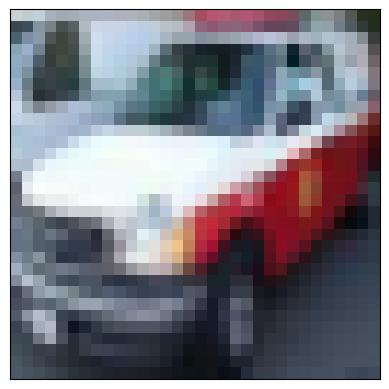

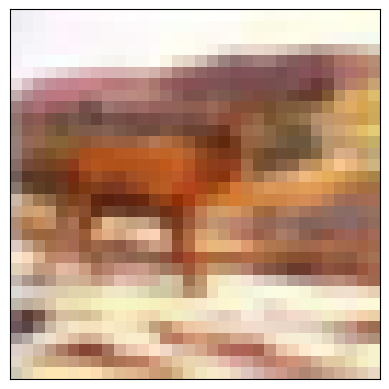

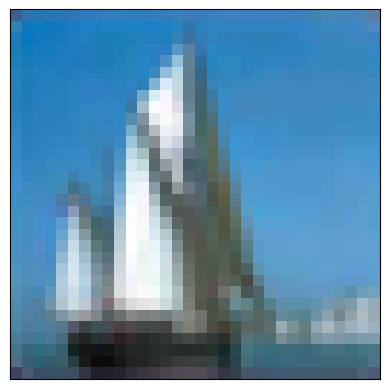

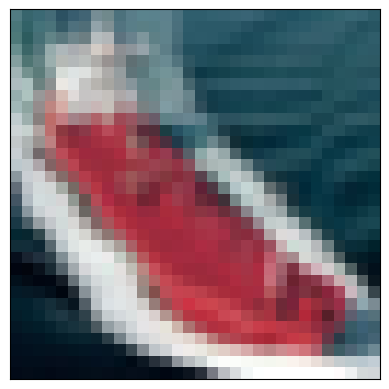

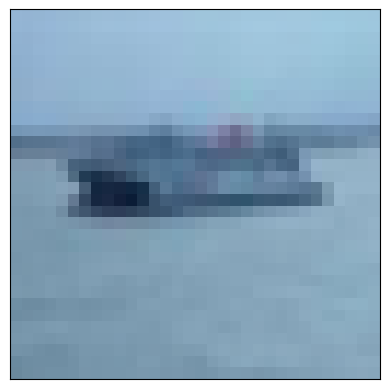

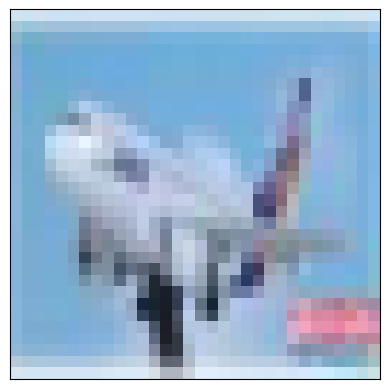

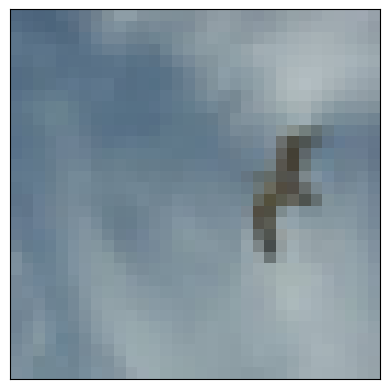

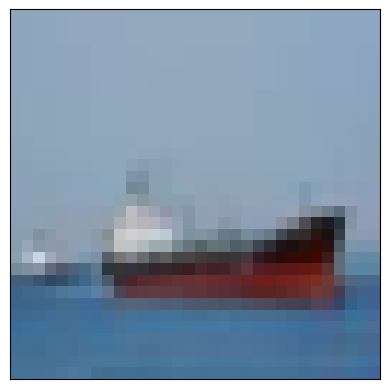

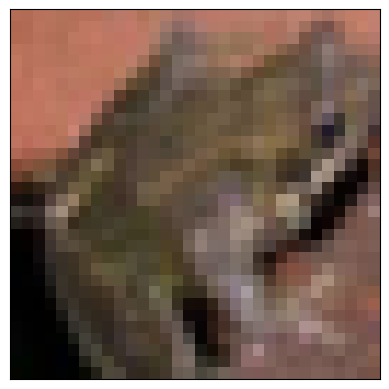

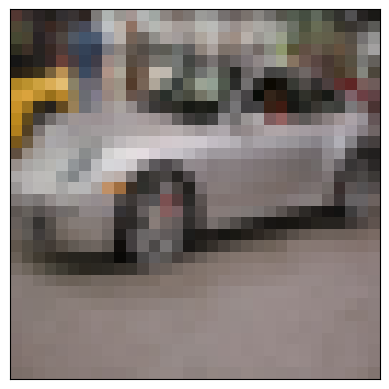

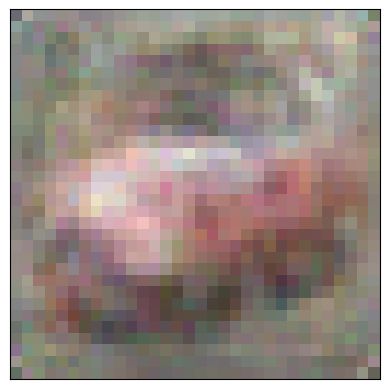

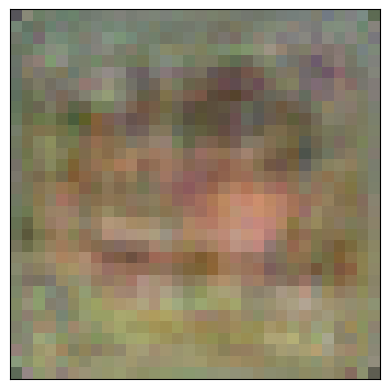

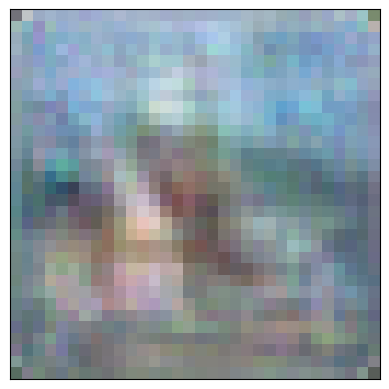

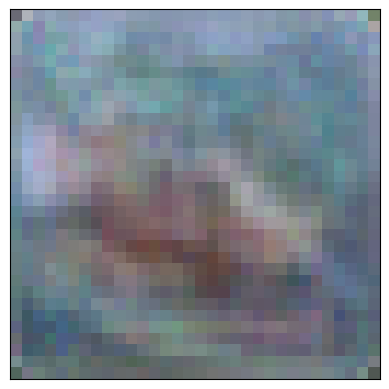

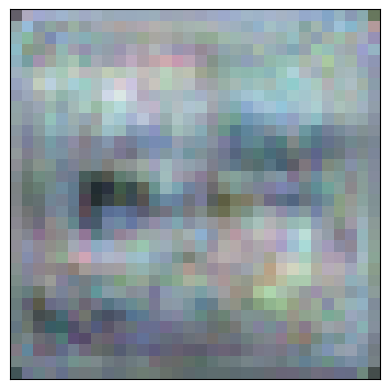

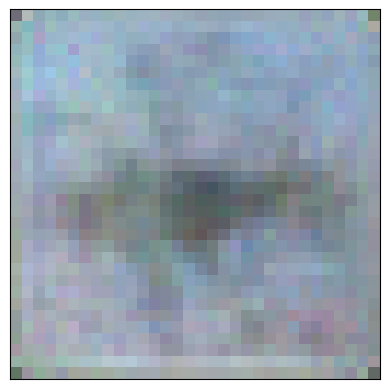

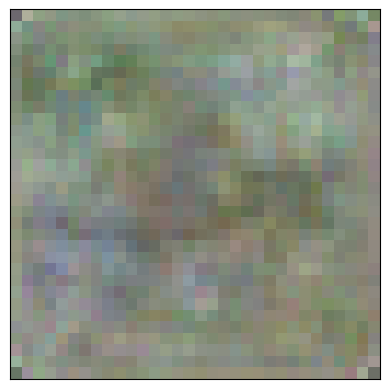

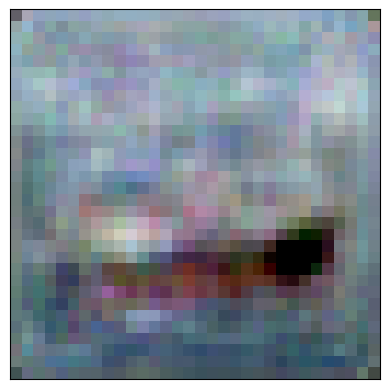

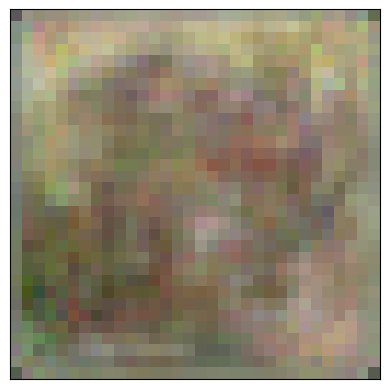

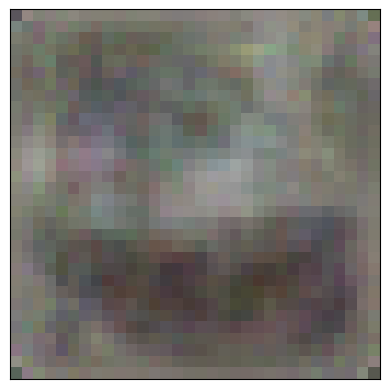

In [31]:
with torch.no_grad():
    for codes, labels, imgs in train_loader_mem:
        for img in imgs[:10]:
            show(img)
        imgs = imgs.to(device)
        imgrecons = model.forward_transposed(codes)
        for imgrecon in imgrecons[:10]:
            show(imgrecon)
        break